# Storytelling Exercise 

### Assignment:
How does one go about creating a data story? You have some pointers from the material you've just gone through, but they’re probably a bit on the abstract side when you’re just getting started. Also, storytelling is an art, so you have to get your imagination going. Here are some pointers to get those creative juices flowing. In the following sections we will work step-by-step to create your first Data Story

Pick a dataset - ideally the dataset for your Capstone. If for some reason you want to do this on a different data set, you can find one on Mode Analytics or Google's public data sets directory, or pick another one you like from elsewhere.

Get going by asking the following questions and looking for the answers with some code and plots:
*- Can you count something interesting?
*- Can you find some trends (high, low, increase, decrease, anomalies)?
*- Can you make a bar plot or a histogram?
*- Can you compare two related quantities?
*- Can you make a scatterplot?
*- Can you make a time-series plot?

Having made these plots, what are some insights you get from them? Do you see any correlations? Is there a hypothesis you would like to investigate further? What other questions do they lead you to ask?

By now you’ve asked a bunch of questions, and found some neat insights. Is there an interesting narrative, a way of presenting the insights using text and plots from the above, that tells a compelling story? As you work out this story, what are some other trends/relationships you think will make it more complete?

Submission Requirements: Submit links to a Github repository containing a Jupyter notebook. The notebook should contain:

The questions you asked The trends you investigated The resulting visualizations and conclusions. In case the data set is too large to commit to Github, please include a link to the data set inside the Jupyter notebook.

## Data Acquisition
Mine is from [Kaggle](https://www.kaggle.com/tunguz/pharmaceutical-drug-spending-by-countries) and it explores pharmaceutical drug spending by countries with indicators such as a share of total health spending, in USD per capita (using economy-wide PPPs) and as a share of GDP. Plus, total spending by each countries in the specific year. Data comes from [Organisation for Economic Cooperation and Development](https://data.oecd.org/healthres/pharmaceutical-spending.htm). Population data comes from [DataHub](http://datahub.io/core/population)Columns such as 'Total Spend' was calculated using 'US dollars per capita' and 'population data'. 

In [137]:
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('ggplot')
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [138]:
# Set chart defaults
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [139]:
drug_spending_df = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Springboard_\Storytelling\data_csv.csv')
drug_spending_df.head()

,LOCATION,TIME,PC_HEALTHXP,PC_GDP,USD_CAP,FLAG_CODES,TOTAL_SPEND
0,AUS,1971,15.992,0.727,35.720,NaN,462.11
1,AUS,1972,15.091,0.686,36.056,NaN,475.11
2,AUS,1973,15.117,0.681,39.871,NaN,533.47
3,AUS,1974,14.771,0.755,47.559,NaN,652.65
4,AUS,1975,11.849,0.682,47.561,NaN,660.76


## Data Cleaning and Wrangling

In [140]:
# Let's clean
drug_spending_df.rename({'LOCATION':'Location', 'TIME':'Year', 'PC_HEALTHXP':'Per_Capita_HealthXP', 'USD_CAP':'USD_Cap', 'FLAG_CODES':'Flag_Code', 'TOTAL_SPEND':'Tot_Spend'}, axis=1, inplace=True)
drug_spending_df

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Flag_Code,Tot_Spend
0,AUS,1971,15.992,0.727,35.720,NaN,462.11
1,AUS,1972,15.091,0.686,36.056,NaN,475.11
2,AUS,1973,15.117,0.681,39.871,NaN,533.47
3,AUS,1974,14.771,0.755,47.559,NaN,652.65
4,AUS,1975,11.849,0.682,47.561,NaN,660.76
...,...,...,...,...,...,...,...
1031,LTU,2012,28.942,1.820,448.728,NaN,1340.70
1032,LTU,2013,28.173,1.728,461.178,NaN,1364.02
1033,LTU,2014,27.836,1.724,485.245,NaN,1422.92
1034,LTU,2015,26.784,1.745,504.422,NaN,1465.30


In [141]:
drug_spending_df.Flag_Code.unique()

array([nan, 'B', 'D', 'P'], dtype=object)

In [142]:
drug_spending_df.Flag_Code.isnull().sum() # we got 973. That's 93% of data missing for Flag Codes, we can drop it

973

In [143]:
drug_spending_df = drug_spending_df.drop(columns='Flag_Code')

In [144]:
drug_spending_df

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend
0,AUS,1971,15.992,0.727,35.720,462.11
1,AUS,1972,15.091,0.686,36.056,475.11
2,AUS,1973,15.117,0.681,39.871,533.47
3,AUS,1974,14.771,0.755,47.559,652.65
4,AUS,1975,11.849,0.682,47.561,660.76
...,...,...,...,...,...,...
1031,LTU,2012,28.942,1.820,448.728,1340.70
1032,LTU,2013,28.173,1.728,461.178,1364.02
1033,LTU,2014,27.836,1.724,485.245,1422.92
1034,LTU,2015,26.784,1.745,504.422,1465.30


In [145]:
drug_spending_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Location             1036 non-null   object 
 1   Year                 1036 non-null   int64  
 2   Per_Capita_HealthXP  1036 non-null   float64
 3   PC_GDP               1036 non-null   float64
 4   USD_Cap              1036 non-null   float64
 5   Tot_Spend            1036 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 48.7+ KB


In [146]:
drug_spending_df.isnull().sum()

Location               0
Year                   0
Per_Capita_HealthXP    0
PC_GDP                 0
USD_Cap                0
Tot_Spend              0
dtype: int64

In [147]:
drug_spending_df.Tot_Spend.unique()

array([  462.11,   475.11,   533.47, ...,  1422.92,  1465.3 , 44655.62])

In [148]:
drug_spending_df.Tot_Spend.isnull().sum()

0

### Create a new column for Region

This will make things simpler when comparing values. 

In [159]:
drug_spending_df['Location']

0       AUS
1       AUS
2       AUS
3       AUS
4       AUS
       ... 
1031    LTU
1032    LTU
1033    LTU
1034    LTU
1035    RUS
Name: Location, Length: 1036, dtype: object

In [162]:
region = {
    'AUS' : 'Oceania',
    'AUT' : 'Europe',
    'BEL' : 'Europe',
    'CAN' : 'North America',
    'CZE' : 'Europe',
    'DNK' : 'Europe',
    'FIN' : 'Europe',
    'FRA' : 'Europe',
    'DEU' : 'Europe',
    'GRC' : 'Europe',
    'HUN' : 'Europe',
    'ISL' : 'Asia',
    'ISR' : 'Asia',
    'IRL' : 'Europe',
    'ITA' : 'Europe',
    'JPN' : 'Asia',
    'KOR' : 'Asia',
    'LTU' : 'Europe',
    'LUX' : 'Europe',
    'LVA' : 'Europe',
    'MEX' : 'North America',
    'NLD' : 'Europe',
    'NZL' : 'Oceania',
    'NOR' : 'Europe',
    'POL' : 'Europe',
    'PRT' : 'Europe',
    'SVK' : 'Europe',
    'ESP' : 'Europe',
    'SWE' : 'Europe',
    'CHE' : 'Europe',
    'TUR' : 'Asia',
    'GBR' : 'Europe',
    'RUS' : 'Europe',
    'USA' : 'North America',
    'EST' : 'Europe',
    'SVN' : 'Europe'
}

drug_spending_df['Region'] = drug_spending_df['Location'].map(region)

# value counts for each Region
drug_spending_df['Region'].value_counts() 

drug_spending_df.sample(4)

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend,Region,Decade
100,BEL,2005,17.026,1.536,512.107,5366.17,Europe,2000s
51,AUT,1997,11.213,1.010,255.927,2039.24,Europe,90s
425,ISL,2007,13.505,1.178,479.640,149.44,Asia,2000s
6,AUS,1977,10.087,0.613,47.649,676.23,Oceania,70s


In [164]:
drug_spending_df['Region'].unique()

array(['Oceania', 'Europe', 'North America', 'Asia'], dtype=object)

### Create a new column for Decades

Realizing years are entered as 1971, 1972, 1973 and so on, we can make things simpler, again, by adding column designated for decades. 

In [165]:
decade = {
    1970 : '70s', 
    1971 : '70s', 
    1972 : '70s', 
    1973 : '70s', 
    1974 : '70s', 
    1975 : '70s', 
    1976 : '70s', 
    1977 : '70s', 
    1978 : '70s', 
    1979 : '70s', 
    1980 : '80s', 
    1981 : '80s', 
    1982 : '80s', 
    1983 : '80s', 
    1984 : '80s',
    1985 : '80s', 
    1986 : '80s', 
    1987 : '80s', 
    1988 : '80s', 
    1989 : '80s',
    1990 : '90s', 
    1991 : '90s', 
    1992 : '90s', 
    1993 : '90s', 
    1994 : '90s',
    1995 : '90s', 
    1996 : '90s', 
    1997 : '90s', 
    1998 : '90s', 
    1999 : '90s',
    2000 : '2000s', 
    2001 : '2000s', 
    2002 : '2000s', 
    2003 : '2000s', 
    2004 : '2000s',
    2005 : '2000s', 
    2006 : '2000s', 
    2007 : '2000s', 
    2008 : '2000s', 
    2009 : '2000s',
    2010 : '2010s', 
    2011 : '2010s', 
    2012 : '2010s', 
    2013 : '2010s', 
    2014 : '2010s',
    2015 : '2010s', 
    2016 : '2010s'}

drug_spending_df['Decade'] = drug_spending_df['Year'].map(decade)

# see value counts of each Decade
drug_spending_df['Decade'].value_counts()         

# see new column called Decade
drug_spending_df.sample(4)

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend,Region,Decade
501,ITA,2014,16.944,1.527,554.181,33688.19,Europe,2010s
806,ESP,1981,21.468,1.096,83.527,3153.87,Europe,80s
889,CHE,1991,10.106,0.805,223.999,1523.19,Europe,90s
756,PRT,1983,20.083,0.969,68.948,686.57,Europe,80s


In [166]:
drug_spending_df.Decade.dtype

dtype('O')

In [167]:
# make separate datasets for each decade
_70s = drug_spending_df[drug_spending_df['Decade'].str.contains('70s')]
_80s = drug_spending_df[drug_spending_df['Decade'].str.contains('80s')]
_90s = drug_spending_df[drug_spending_df['Decade'].str.contains('90s')]
_2000s = drug_spending_df[drug_spending_df['Decade'].str.contains('2000s')]
_2010s = drug_spending_df[drug_spending_df['Decade'].str.contains('2010s')]

# Sanity check
_2010s.sample(10)

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend,Region,Decade
578,KOR,2012,24.809,1.669,535.718,26892.96,Asia,2010s
360,GRC,2010,28.633,2.737,771.997,8585.64,Europe,2010s
662,NLD,2015,7.865,0.841,416.594,7057.07,Europe,2010s
1031,LTU,2012,28.942,1.820,448.728,1340.70,Europe,2010s
432,ISL,2014,12.581,1.105,489.466,160.24,Asia,2010s
619,MEX,2014,27.011,1.537,277.229,34437.83,North America,2010s
533,JPN,2012,18.887,2.038,758.189,96766.90,Asia,2010s
615,MEX,2010,31.497,1.896,287.049,33676.28,North America,2010s
178,CZE,2012,21.496,1.511,438.857,4612.73,Europe,2010s
362,GRC,2012,29.055,2.550,644.747,7121.24,Europe,2010s


In [168]:
# make separate datasets for each region
ds_Oceania = drug_spending_df[drug_spending_df['Region'].str.contains('Oceania')]
ds_Asia = drug_spending_df[drug_spending_df['Region'].str.contains('Asia')]
ds_NorthAmerica = drug_spending_df[drug_spending_df['Region'].str.contains('North America')]
ds_Europe = drug_spending_df[drug_spending_df['Region'].str.contains('Europe')]

ds_Asia.sample(4)

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend,Region,Decade
427,ISL,2009,15.665,1.419,582.697,185.59,Asia,2000s
428,ISL,2010,15.813,1.393,535.019,170.16,Asia,2010s
526,JPN,2005,19.794,1.540,487.681,62312.46,Asia,2000s
504,JPN,1980,21.181,1.330,115.359,13471.85,Asia,80s


In [154]:
# We'll make a separate dataframe that has Decade as index, Region as columns, and total spending as values
spending_table = drug_spending_df.pivot_table(index=['Decade'], columns=['Region'], values=['Tot_Spend'], fill_value=0)
spending_table

Tot_Spend                                           
Region          Asia        Europe  North America       Oceania
Decade                                                         
2000s   25096.516129   8520.717943   89464.692000   6636.164286
2010s   37021.708333  11424.889710  133261.786471  13525.462000
70s       118.699000   1346.353291    1038.501000    524.563636
80s      4935.155588   2897.675289    3185.775000    792.365000
90s     13051.791212   5410.626149    8338.174545   2239.891667

## EDA

<AxesSubplot:xlabel='Decade'>

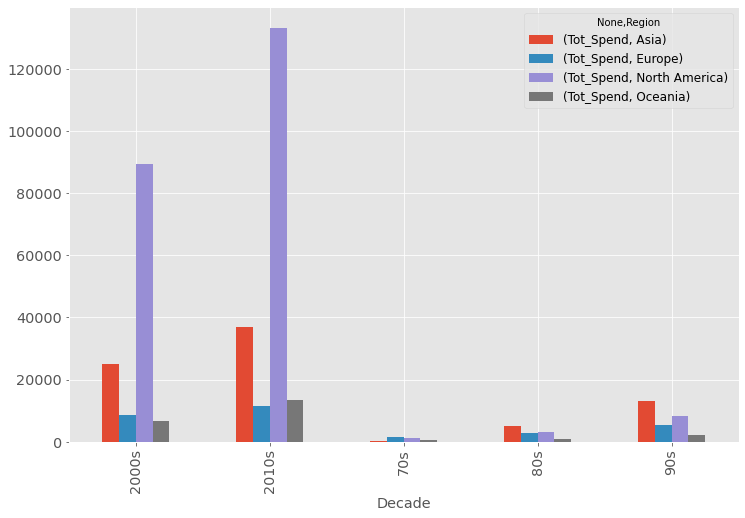

In [135]:
spending_table.plot(kind='bar')